In [11]:
import os
from treeop import str2tree, Tree
from netop import Network
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from netsearch import get_init_nets, supernet_search_mgr

1. Load gene trees. Columns: tree in newick, list of supports, is_bijective.

In [12]:
corona_dir = "../coronavirus_data"
pattern = r"(?<=\))\d+"
trees, support_lists, gene_names, bijectivity, binarity, median_supports = [], [], [], [], [], []
for filename in os.listdir(corona_dir):
    if filename.endswith(".support"):
        gene_name = filename.split("_")[1]
        tree_supports = open(f"{corona_dir}/{filename}").read().strip().strip(";")
        branch_supports = re.findall(pattern, tree_supports)
        branch_supports = [int(support) for support in branch_supports]
        median_support = statistics.median(branch_supports)
        support_lists.append(branch_supports)
        gene_names.append(gene_name)
        median_supports.append(median_support)
    if filename.endswith(".nwk"):
        tree_str = open(f"{corona_dir}/{filename}").read().strip().strip(";")
        is_bijective = len([leaf for leaf in Tree(str2tree(tree_str)).leaves()]) == 15
        bijectivity.append(is_bijective)
        is_binary = Tree(str2tree(tree_str)).is_binary()
        trees.append(tree_str)
        binarity.append(is_binary)

df_trees = pd.DataFrame({"gene_name": gene_names, "tree": trees, "supports": support_lists, "is_bijective": bijectivity, "is_binary": binarity, "median_support": median_supports})
df_trees = df_trees[df_trees["is_bijective"] == True]
df_trees


gene_name                                               tree  \
0         E  (((Rs3367,(((BtCoV2732005,Rf1),(HKU312,BtCoV27...   
1         M  ((GuangxiPangolinP2V,(GuangdongPangolin12019,(...   
2     ORF10  ((((BatCoVZC45,((RaTG13,(HuWuhan2020,HuItalyTE...   
3    ORF1ab  (((BatCoVZXC21,BatCoVZC45),((GuangxiPangolinP2...   
4     ORF3a  ((((BatCoVZXC21,BatCoVZC45),((RaTG13,(HuItalyT...   
5      ORF6  (((GuangdongPangolin12019,((BatCoVZC45,BatCoVZ...   

                                            supports  is_bijective  is_binary  \
0   [95, 74, 42, 56, 92, 96, 99, 28, 39, 91, 40, 59]          True       True   
1  [95, 39, 82, 38, 100, 88, 100, 100, 57, 100, 2...          True       True   
2   [12, 16, 75, 51, 13, 63, 77, 19, 10, 14, 49, 97]          True       True   
3  [100, 100, 100, 98, 93, 100, 100, 99, 73, 100,...          True       True   
4  [90, 100, 89, 100, 52, 76, 100, 100, 100, 100,...          True       True   
5   [99, 77, 99, 55, 56, 93, 51, 99, 86, 84, 27, 49]          True       True   

   median_support  
0            66.5  
1            85.0  
2            34.0  
3           100.0  
4           100.0  
5            80.5

2. Plot: x - name of gene tree, y - boxplot of supports

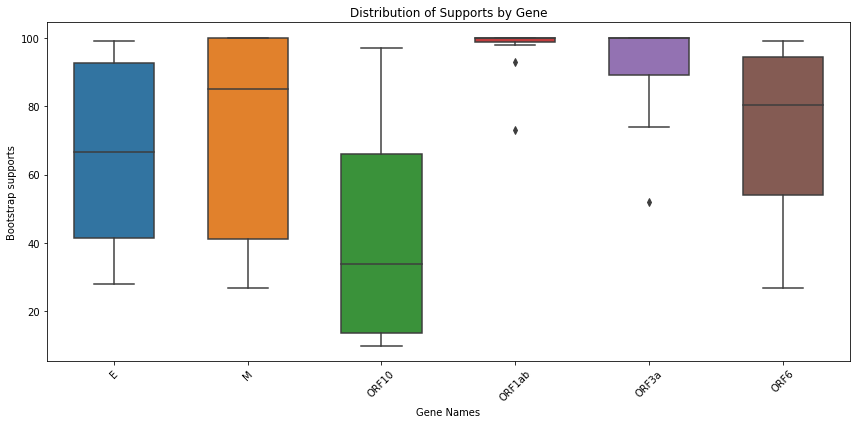

In [13]:
df_exploded = df_trees.explode('supports')

# Create a boxplot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_exploded, x='gene_name', y='supports', width=0.6)

# Set labels and title
plt.xlabel('Gene Names')
plt.ylabel('Bootstrap supports')
plt.title('Distribution of Supports by Gene')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()







 Genes with found recombinations: M, ORF1ab, ORF3a, ORF6, ORF8, and ORF10. ORF8 is not bijective though. Ask about supports for S?

3. Make two datasets: all trees and well-supported trees.

In [14]:
all_trees = list(df_trees["tree"])
all_trees = [Tree(str2tree(tree)) for tree in all_trees]
well_supported_trees = list(df_trees[df_trees["median_support"] > 80]["tree"])
well_supported_trees = [Tree(str2tree(tree)) for tree in well_supported_trees]
print(f"All: {len(all_trees)}")
print(f"Well supported: {len(well_supported_trees)}")

All: 6
Well supported: 4


4. Read 8 networks with 7 reticulations and check whether any of them is relaxed. Compute RF costs for each network

In [15]:
def compute_rf_cost(network, tree):
    min_cost = float("inf")
    for dtree_str in network.displayedtrees():
        dtree = Tree(str2tree(dtree_str))
        curr_cost = dtree.rfcost2(tree)
        min_cost = min(curr_cost, min_cost)
    return min_cost

In [16]:
networks_dir = "../coronavirus_data/7reticulations"
networks, is_relaxed_list, network_names, rf_costs_all, rf_costs_supported = [], [], [], [], []
for filename in os.listdir(networks_dir):
    network_type = filename.split("_")[-1]
    network_str = open(f"{networks_dir}/{filename}").read().strip().strip(";")
    network = Network(str2tree(network_str))
    is_relaxed = network.type1net()
    curr_rf_costs = [compute_rf_cost(network, tree) for tree in all_trees]
    curr_rf_costs_supported = [compute_rf_cost(network, tree) for tree in well_supported_trees]

    # append results
    is_relaxed_list.append(is_relaxed)
    networks.append(network_str)
    network_names.append(network_type)
    rf_costs_all.append(curr_rf_costs)
    rf_costs_supported.append(curr_rf_costs_supported)



df_networks = pd.DataFrame({"network_variant": network_names, "network": networks, "is_relaxed": is_relaxed_list, "all_costs": rf_costs_all, "well_supported_costs": rf_costs_supported})
df_networks

network_variant                                            network  \
0             LLL  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   
1             LLP  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   
2             LPL  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   
3             LPP  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   
4             PLL  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   
5             PLP  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   
6             PPL  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   
7             PPP  ((BM4831BGR2008,(((((Rs3367,#H3))#H4,(SARSCoVB...   

   is_relaxed            all_costs well_supported_costs  
0       False  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]  
1       False  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]  
2       False  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]  
3       False  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]  
4        True  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]  
5        True  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]  
6       False  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]  
7        True  [4, 4, 10, 4, 0, 2]         [4, 4, 0, 2]

TODO: check why the results are weird, maybe find used displayed trees? Check whether the results look better on all gene trees. Also, try comparing the results, i.e. reticulation usage to the reticulation usage from our previous paper.

5. Compute cost for each network and tree and the total cost

In [17]:
def compute_rf_cost(network_str, tree_str):
    network, tree = Network(str2tree(network_str)), Tree(str2tree(tree_str))
    min_cost = float("inf")
    for dtree_str in network.displayedtrees():
        dtree = Tree(str2tree(dtree_str))
        curr_cost = dtree.rfcost2(tree)
        min_cost = min(curr_cost, min_cost)
    return min_cost


6. Plot: network variant on x axis, histogram of costs on y axis and line of total cost on y axis

--------SUPERNETWORKS---------
Generate random starting TC networks and infer RF TC supernetworks

In [18]:
# reticulations = 7 # todo: modify depending on the used reticulations described in the Makarenkov paper
# starting_networks = get_init_nets(gene_trees=all_trees, reticulations=reticulations, nets_number=10)
# starting_networks

In [19]:
# supernet_results = supernet_search_mgr(gene_trees=all_trees, init_nets=starting_networks)
# supernet_results
